# Homework 3

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr

# import statsmodels functions
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa import stattools as st
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# This code will supress certain unnecessary warnings from the statsmodels package
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', module='statsmodels', category=FutureWarning)
warnings.filterwarnings('ignore', module='statsmodels', category=ValueWarning)

Using `pandas_datareader` to download daily prices for the S&P 500 index from Yahoo!, beginning in 1980.

**Important**: Before proceeding, multiply the return by 100 to put it in percent terms. This is important for the algorithms that estimate the ARMA models you'll be using.

In [6]:
sp500 = pdr.get_data_yahoo('^GSPC', 1980)
sp500["daily_return"] = sp500["Adj Close"].pct_change(1) * 100
sp500

,High,Low,Open,Close,Volume,Adj Close,daily_return
Date,,,,,,,
1980-01-02,108.430000,105.290001,0.000000,105.760002,40610000,105.760002,NaN
1980-01-03,106.080002,103.260002,0.000000,105.220001,50480000,105.220001,-0.510591
1980-01-04,107.080002,105.089996,0.000000,106.519997,39130000,106.519997,1.235502
1980-01-07,107.800003,105.800003,0.000000,106.809998,44500000,106.809998,0.272250
1980-01-08,109.290001,106.290001,0.000000,108.949997,53390000,108.949997,2.003557
...,...,...,...,...,...,...,...
2021-03-22,3955.310059,3914.159912,3916.479980,3940.590088,4311380000,3940.590088,0.702512
2021-03-23,3949.129883,3901.570068,3937.600098,3910.520020,4645340000,3910.520020,-0.763085
2021-03-24,3942.080078,3889.070068,3919.929932,3889.139893,4766990000,3889.139893,-0.546734


What is the average daily return? Is it statistically significant at the 5% level?

In [23]:
avg_return = sp500["daily_return"].mean()
n = len(sp500["daily_return"])-sum(sp500["daily_return"].isna())
std_return = np.std(sp500["daily_return"])

conf_lower = avg_return - (1.96 * (std_return/np.sqrt(n)))
conf_upper = avg_return + (1.96 * (std_return/np.sqrt(n)))
print("Average Daily Return: " + str(avg_return))
print("Confidence Interval: " + "(" + str(conf_lower) + "," + str(conf_upper) + ")")

Average Daily Return: 0.04132078752448043
Confidence Interval: (0.019587789943823028,0.06305378510513783)


The average daily return is about .04%. Under the null hypothesis that the average daily return is 0, the observed return is statistically significant at 95%, indicated by 0 being outside the bounds of the confidence interval.

Plot the ACF for daily returns in two time periods: 1980-1999 and 2000-present. Do a Ljung-Box test with $m=20$. What is the $p$-value of this test? Interpret this result, being sure to comment on any differences you see between the two periods.

In [37]:
sp500_first = sp500.loc['1980':'1999',"daily_return"]
sp500_first.dropna(inplace=True)
sp500_first

Date
1980-01-03   -0.510591
1980-01-04    1.235502
1980-01-07    0.272250
1980-01-08    2.003557
1980-01-09    0.091791
                ...   
1999-12-27   -0.085028
1999-12-28    0.038437
1999-12-29    0.397893
1999-12-30    0.069015
1999-12-31    0.326400
Name: daily_return, Length: 5055, dtype: float64

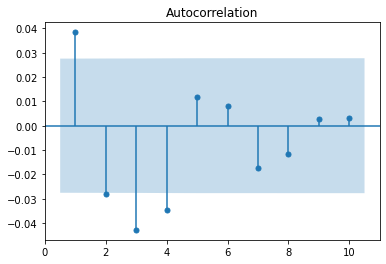

In [38]:
fig = sm.graphics.tsa.plot_acf(sp500_first, lags=10, zero=False)

In [39]:
sp500_second = sp500.loc['2000':,"daily_return"]
sp500_second.dropna(inplace=True)
sp500_second

Date
2000-01-03   -0.954911
2000-01-04   -3.834467
2000-01-05    0.192218
2000-01-06    0.095568
2000-01-07    2.709040
                ...   
2021-03-22    0.702512
2021-03-23   -0.763085
2021-03-24   -0.546734
2021-03-25    0.524027
2021-03-26    1.663120
Name: daily_return, Length: 5342, dtype: float64

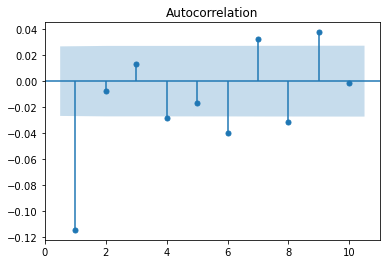

In [40]:
fig = sm.graphics.tsa.plot_acf(sp500_second, lags=10, zero=False)

In [87]:
m = 20

acfs1 = st.acf(sp500_first, nlags=m+1)
acfs2 = st.acf(sp500_second, nlags=m+1)

T1 = len(sp500_first)
k1 = np.arange(1,len(acfs1))

T2 = len(sp500_second)
k2 = np.arange(1,len(acfs2))

# Q(m) statistic
q1 = T1 * (T1+2) * (acfs1[1:]**2 / (T1-k1)).sum()
print(q1)

q2 = T2 * (T2+2) * (acfs2[1:]**2 / (T2-k2)).sum()
print(q2)

from scipy.stats import chi2

chi2.ppf(0.95, df=m)

38.16428152705129
182.77126965488898


31.410432844230918

In [85]:
acf1, qstats1, pvals1 = st.acf(sp500_first, nlags=m, qstat=True)
print(pvals1)

[6.30956340e-03 3.25367736e-03 1.19224878e-04 2.15317164e-05
 4.46908870e-05 9.93506565e-05 1.21251567e-04 2.03704375e-04
 4.16689216e-04 7.99098413e-04 5.57214203e-04 6.84429653e-04
 9.91321271e-04 1.00119892e-03 1.67037610e-03 2.53308776e-03
 2.68560343e-03 4.21503003e-03 6.32781297e-03 8.87116297e-03]


In [51]:
acf2, qstats2, pvals2 = st.acf(sp500_second, nlags=m, qstat=True)
print(pvals2)

[5.02924467e-17 4.61043394e-16 1.92850844e-15 1.22466478e-15
 2.80728075e-15 2.14102437e-16 5.79141470e-17 1.88357372e-17
 1.97051834e-18 6.94950840e-18 1.38817713e-17 2.56848326e-19
 4.22800310e-19 1.26953686e-18 2.37226700e-22 5.39630841e-28
 1.56560161e-27 6.16011578e-29 1.97301728e-28 6.20539332e-28]


The p-values for each of the time periods are very low, an indication that there is some autocorrelation in the data up to 20 lags using a 95% confidence interval. It also seems like there is stronger evidence of this in the more recent data, as the p-values are significantly lower for the data since 2000 than 1980-1999. This can also be seen with the Q-stat, which is much farther than the 95% Q-stat from the chi distribution for the second set of data than the first.

Again, using two separate time periods (1980–1999 and 2000–present), use the BIC to select the order $p$ of an $AR(p)$ model for daily returns. (Consider up to 10 lags.)

Then estimate the model using `AutoReg` and report both serial correlation and Normality tests of the residuals. Discuss your results.

In [71]:
modselect1 = ar_select_order(sp500_first, maxlag=10, old_names=False)
modselect1.bic

{0: -0.022253637540028903,
 (1,): -0.02204024600405499,
 (1, 2): -0.02127634862951138,
 (1, 2, 3): -0.0212337311330017,
 (1, 2, 3, 4): -0.020619481997988416,
 (1, 2, 3, 4, 5): -0.019071994110662113,
 (1, 2, 3, 4, 5, 6): -0.01739396726886336,
 (1, 2, 3, 4, 5, 6, 7): -0.016113536461810875,
 (1, 2, 3, 4, 5, 6, 7, 8): -0.014521807595252845,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): -0.012846566955178475,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): -0.01115780931675582}

In [72]:
modselect2 = ar_select_order(sp500_second, maxlag=10, old_names=False)
modselect2.bic

{(1,): 0.4354961729786091,
 (1, 2): 0.4366856427019028,
 (1, 2, 3): 0.43815065924666136,
 (1, 2, 3, 4): 0.43909739547456406,
 (1, 2, 3, 4, 5, 6): 0.43957415034034203,
 (1, 2, 3, 4, 5): 0.4401353318915507,
 (1, 2, 3, 4, 5, 6, 7): 0.4406265763719927,
 (1, 2, 3, 4, 5, 6, 7, 8): 0.44156373099027507,
 (1, 2, 3, 4, 5, 6, 7, 8, 9): 0.44212843856032336,
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10): 0.44373087829340885,
 0: 0.4473983750704926}

In [94]:
res1 = AutoReg(sp500_first, lags=0).fit()
print(res1.summary())

                            AutoReg Model Results                             
Dep. Variable:           daily_return   No. Observations:                 5055
Model:                     AutoReg(1)   Log Likelihood               -7105.799
Method:               Conditional MLE   S.D. of innovations              0.987
Date:                Sun, 28 Mar 2021   AIC                             -0.025
Time:                        21:18:29   BIC                             -0.021
Sample:                             1   HQIC                            -0.023
                                 5055                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0549      0.014      3.950      0.000       0.028       0.082
daily_return.L1     0.0384      0.014      2.732      0.006       0.011       0.066
                                

In [95]:
res1.test_serial_correlation(10)

,Ljung-Box,LB P-value,DF
Lag,,,
1,0.008235,NaN,0
2,3.973848,0.046212,1
3,12.199864,0.002243,2
4,17.913782,0.000458,3
5,18.772932,0.000871,4
6,19.120139,0.001826,5
7,20.647182,0.002122,6
8,21.249175,0.003418,7
9,21.299083,0.006394,8


In [124]:
res1.test_normality()

Jarque-Bera    351195.176901
P-value             0.000000
Skewness           -1.844743
Kurtosis           43.670789
dtype: float64

In [77]:
res2 = AutoReg(sp500_second, lags=1).fit()
print(res2.summary())

                            AutoReg Model Results                             
Dep. Variable:           daily_return   No. Observations:                 5342
Model:                     AutoReg(1)   Log Likelihood               -8738.049
Method:               Conditional MLE   S.D. of innovations              1.242
Date:                Sun, 28 Mar 2021   AIC                              0.435
Time:                        18:04:18   BIC                              0.439
Sample:                             1   HQIC                             0.437
                                 5342                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0297      0.017      1.744      0.081      -0.004       0.063
daily_return.L1    -0.1147      0.014     -8.440      0.000      -0.141      -0.088
                                

In [78]:
res2.test_serial_correlation(10)

,Ljung-Box,LB P-value,DF
Lag,,,
1,0.044242,NaN,0
2,2.078106,0.149425,1
3,2.587197,0.274282,2
4,7.221606,0.065160,3
5,10.548804,0.032131,4
6,18.688863,0.002196,5
7,22.090057,0.001166,6
8,25.124707,0.000721,7
9,31.715022,0.000105,8


In [125]:
res2.test_normality()

Jarque-Bera    22633.896242
P-value            0.000000
Skewness          -0.285281
Kurtosis          13.068803
dtype: float64

The BIC seems to favor a smaller number of lags for each of the datasets, which is understandable because of the penalty the BIC puts on extra variables as described in class. The earlier set of data says that zero lags in the AR model is the best fit, although this does not seem to match with the serial correlation test, which gives a much higher p-value for the first lag with one lag in the AutoReg model compared to zero, which indicates there is less unexplained structure in the residuals. For the later set of data, the BIC indicates that one lag would be the optimal AutoReg model, and this proves to be helpful with fairly high p-values for each of the first four lags in the Ljung-Box test.

Next, estimate various ARMA($p$,$q$) models in each of the two sub-periods. Use a loop to try all values of $p$ and $q$ from 0 up to 4. Then choose the *simplest* model that generates residuals where the Ljung-Box $Q(10)$ cannot reject the null of no serial correlation.

Comment on the results!

<hr>

**Pro tip**: After estimating a model with `ARIMA`, we can test the serial correlation of the residuals like this:

`lb = arma.test_serial_correlation('ljungbox')`

The $p$-values for this test are then stored in this array:

`lb[0][-1]`

In [99]:
#min_q = chi2.ppf(0.95, df=10)

In [103]:
# restest = ARIMA(sp500_first,order=(0,0,0)).fit()
# lb = restest.test_serial_correlation('ljungbox')
# lb[0][-1]

array([6.30956340e-03, 3.25367736e-03, 1.19224878e-04, 2.15317164e-05,
       4.46908870e-05, 9.93506565e-05, 1.21251567e-04, 2.03704375e-04,
       4.16689216e-04, 7.99098413e-04])

In [114]:
#Finding best for first set
p1 = 5
q1s = 5
for p in range(0,5):
    for q in range(0,5):
        usable = 0
        arma = ARIMA(sp500_first,order=(p,0,q)).fit()
        lb1 = arma.test_serial_correlation('ljungbox')
        p_values = lb1[0][-1]
        for value in p_values:
            if value > .05:
                usable += 1
            else:
                pass
        if usable != 0 and (p+q) < (p1+q1s):
            p1 = p
            q1s = q
        else:
            pass
print(p1)
print(q1s)

0
1


The simplest model for the first dataset that generates residuals where at least one of the lags in the model cannot be rejected due to serial correlation is an ARMA(0,1) model. An ARMA(1,0) also has p-values for the first two lags that do not reject the null of no serial correlation.

In [113]:
# arma1 = ARIMA(sp500_first,order=(0,0,1)).fit()
# lbt = arma1.test_serial_correlation('ljungbox')
# lbt[0][-1]

array([0.94343785, 0.17046632, 0.00810901, 0.00154418, 0.00254368,
       0.00472459, 0.00511908, 0.00763628, 0.01323707, 0.0214123 ])

In [115]:
#Finding best for second set
p2 = 5
q2 = 5
for p in range(0,5):
    for q in range(0,5):
        usable = 0
        arma = ARIMA(sp500_second,order=(p,0,q)).fit()
        lb2 = arma.test_serial_correlation('ljungbox')
        p_values = lb2[0][-1]
        for value in p_values:
            if value > .05:
                usable += 1
            else:
                pass
        if usable != 0 and (p+q) < (p2+q2):
            p2 = p
            q2 = q
        else:
            pass
print(p2)
print(q2)

C:\Users\Edward\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Edward\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Edward\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0
1


The simplest model for the second dataset for which the ljung-box test cannot reject the null is also an ARMA(0,1) test, though the p-values are notably smaller. The ARMA(1,0) model would also work for this dataset.

In [118]:
# arma2 = ARIMA(sp500_second,order=(1,0,0)).fit()
# lbt = arma2.test_serial_correlation('ljungbox')
# lbt[0][-1]

array([8.59765604e-01, 3.57375480e-01, 4.63488403e-01, 1.20819925e-01,
       5.82853255e-02, 4.60314069e-03, 2.37144588e-03, 1.41418098e-03,
       2.17318225e-04, 4.33588038e-04])

## Monthly data

Finally, do the Ljung-Box test on *monthly* returns data during the two periods. Comment on the similarity or difference of these results to what you found using daily data above.

<hr>

**Pro tip**: Recall that we can go from daily to monthly data by resampling the price series:

`sp500['Adj Close'].resample('M').last().pct_change()`

In [134]:
monthly1 = sp500_first.resample('M').last().pct_change()
monthly2 = sp500_second.resample('M').last().pct_change()
monthly1.dropna(inplace=True)
monthly2.dropna(inplace=True)

In [135]:
m = 20

acfs11 = st.acf(monthly1, nlags=m+1)
acfs22 = st.acf(monthly2, nlags=m+1)

T11 = len(monthly1)
k11 = np.arange(1,len(acfs11))

T22 = len(monthly2)
k22 = np.arange(1,len(acfs22))

# Q(m) statistic
q11 = T11 * (T11+2) * (acfs11[1:]**2 / (T11-k11)).sum()
print(q11)

q22 = T22 * (T22+2) * (acfs22[1:]**2 / (T22-k22)).sum()
print(q22)

from scipy.stats import chi2

chi2.ppf(0.95, df=m)

1.4096183486279739
0.1597190069655866


31.410432844230918

In [137]:
acf11, qstats11, pvals11 = st.acf(monthly1, nlags=m, qstat=True)
print(pvals11)

[0.99370477 0.98877128 0.99833804 0.99981731 0.99927386 0.99985743
 0.99996055 0.99999343 0.99999764 0.99999922 0.99999987 0.9999988
 0.99999945 0.99999981 0.99999996 0.99999999 1.         1.
 1.         1.        ]


In [138]:
acf22, qstats22, pvals22 = st.acf(monthly2, nlags=m, qstat=True)
print(pvals22)

[0.9603548  0.99700855 0.99922624 0.99993798 0.99999551 0.99999967
 0.99999993 0.9999999  0.99999999 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


The results are extremely different for monthly data. The Q-stat is much lower than the Q critical value required to reject the null at 95% confidence, and the p values for each time period are very large, suggesting no autocorrelation in the monthly data.